In [1]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt


2023-04-24 17:19:55.487046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 17:19:55.554630: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
IMAGE_DIR = "/data2/SrikanthData/ResearchWork2/tensorflow/Project/img_data/ORIGA/Images"

MASK_DIR = "/data2/SrikanthData/ResearchWork2/tensorflow/Project/img_data/ORIGA/mask_cup"
BATCH_SIZE = 4

In [3]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(
        n_filters,
        3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(x)
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(
        n_filters,
        3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = tf.keras.layers.concatenate([x, conv_features])
    # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def create_unet():
    # inputs
    inputs = tf.keras.layers.Input(shape=(128,128,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 32) # 64
    # 2 - downsample
    f2, p2 = downsample_block(p1, 64) # 128
    # 3 - downsample
    f3, p3 = downsample_block(p2, 128) # 256
    # 4 - downsample
    f4, p4 = downsample_block(p3, 256) # 512
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 256) # 1024

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 256) # 512
    # 7 - upsample
    u7 = upsample_block(u6, f3, 128) # 256
    # 8 - upsample
    u8 = upsample_block(u7, f2, 64) # 128
    # 9 - upsample
    u9 = upsample_block(u8, f1, 32)
    # outputs
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model



In [4]:
# load data
assert len(os.listdir(IMAGE_DIR)) == len(os.listdir(MASK_DIR)), "Different number of images and masks"
X, Y, file_names = [], [], []
for image_name in sorted(os.listdir(IMAGE_DIR)):
    mask_name = "image_"+ image_name[:3] + ".png"
    

    image = cv2.imread(os.path.join(IMAGE_DIR, image_name))
    image = cv2.resize(image, (256, 256))
    

    mask = cv2.imread(os.path.join(MASK_DIR, mask_name))
    mask = cv2.resize(mask, (256, 256))


    X.append(image)
    Y.append(mask)
    file_names.append(image_name)


In [5]:
def dice_coef(y_true, y_pred): # accuracy function 
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-6)
  
def dice_loss(y_true,y_pred): # loss function 
    return -dice_coef(y_true,y_pred)
  
def log_dice_loss(y_true, y_pred):
    return -tf.math.log(dice_coef(y_true, y_pred))



def iou(y_true, y_pred, threshold=0.5):                                                             
    y_true = tf.reshape(y_true, [-1])                                                               
    y_true = tf.cast(y_true, tf.float32)                                                            
    y_pred = tf.cast(y_pred > threshold, tf.float32)                                                
                                                                                                    
    y_pred = tf.reshape(y_pred, [-1])                                                               
                                                                                                    
                                                                                                    
    intersection = tf.reduce_sum(y_true*y_pred)                                                     
    union = tf.reduce_sum(tf.cast(y_true + y_pred > 0, tf.float32))                                 
                                                                                                    
    return intersection/union 

In [6]:
def augmentation_fn(image, mask, training=True):
    """
    Augmentation for training set only. random cropy 50% of the time, random flip 50% of the time
    """
    # change brightness

    image = image.copy()
    mask = mask.copy()
    if training:
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_hue(image, 0.1)
    
        seed = np.random.randint(0, 1000, (2, ))
        if np.random.rand() < 0.5:
            random_size = np.random.randint(210, 256) # this is because the size of the image is 256 
        
            image = tf.image.stateless_random_crop(image, [random_size, random_size, 3], seed=seed)
            mask = tf.image.stateless_random_crop(mask, [random_size, random_size, 3], seed=seed)

        if np.random.rand() < 0.5:
            image = tf.image.stateless_random_flip_up_down(image, seed)
            mask = tf.image.stateless_random_flip_up_down(mask, seed)


    image = tf.image.resize(image, (128, 128))/122.5 - 1.0
    print(image.shape)
    mask = tf.cast(tf.image.resize(mask, (128, 128)) > 122.5, float)[:, :, :1]
    
    return image, mask



In [7]:
# Split train and test
mask = list(range(len(X)))
np.random.seed(0)
np.random.shuffle(mask)
n_train = int(0.8*len(mask))
X_train = [X[i] for i in mask[:n_train]]
Y_train = [Y[i] for i in mask[:n_train]]
name_train = [file_names[i] for i in mask[:n_train]]

X_test = [X[i] for i in mask[n_train:]]
Y_test = [Y[i] for i in mask[n_train:]]
name_test = [file_names[i] for i in mask[n_train:]]

def data_generator(X, Y, batch_size=BATCH_SIZE, training=True):
    n_data = len(X)

    i = 0
    while True:
        if i + batch_size > n_data:
            i = 0
            mask = np.arange(n_data)
            np.random.shuffle(mask)

            X = [X[j] for j in mask]
            Y = [Y[j] for j in mask]
        
        mini_X = X[i: i + batch_size] 
        mini_Y = Y[i: i + batch_size]

        
        processed_data = [augmentation_fn(x, y, training) for x, y in zip(mini_X, mini_Y)]
        mini_X = [item[0] for item in processed_data]
        mini_Y = [item[1] for item in processed_data]


        mini_X = tf.concat([tf.expand_dims(_, axis=0) for _ in mini_X], axis=0)
        mini_Y = tf.concat([tf.expand_dims(_, axis=0) for _ in mini_Y], axis=0)

        i += batch_size
        yield mini_X, mini_Y



In [8]:
model = create_unet()

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=log_dice_loss,
    metrics=[dice_coef, iou]
)

train_generator = data_generator(X_train, Y_train, training=True)
validation_generator = data_generator(X_test, Y_test, training=False)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=300,
    validation_data=validation_generator,
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    validation_steps=len(X_test)//BATCH_SIZE,
    callbacks=[early_stopping]
)

2023-04-24 17:20:43.677184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22286 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-04-24 17:20:43.678889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20507 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:3e:00.0, compute capability: 8.6
2023-04-24 17:20:43.679919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 15312 MB memory:  -> device: 2, name: GeForce RTX 3090, pci bus id: 0000:89:00.0, compute capability: 8.6
2023-04-24 17:20:43.681399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22286 MB memory:  -> device: 3, name: GeForce RTX 3090, pci bus id: 0000:b2:00.0, 

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

 concatenate_3 (Concatenate)    (None, 128, 128, 64  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 64  0           ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 32  18464       ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_16[0][0]']              
          

2023-04-24 17:20:46.202316: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-24 17:20:47.572696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-24 17:20:49.476460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


130/130 [==============================] - 14s 36ms/step - loss: 1.7110 - dice_coef: 0.2721 - iou: 0.1971 - val_loss: 0.6991 - val_dice_coef: 0.5125 - val_iou: 0.3618
Epoch 2/300
130/130 [==============================] - 4s 33ms/step - loss: 0.6419 - dice_coef: 0.5421 - iou: 0.3899 - val_loss: 0.5483 - val_dice_coef: 0.5892 - val_iou: 0.4276
Epoch 3/300
130/130 [==============================] - 4s 34ms/step - loss: 0.4558 - dice_coef: 0.6447 - iou: 0.4903 - val_loss: 0.3814 - val_dice_coef: 0.6879 - val_iou: 0.5327
Epoch 4/300
130/130 [==============================] - 4s 33ms/step - loss: 0.4724 - dice_coef: 0.6440 - iou: 0.4893 - val_loss: 0.3777 - val_dice_coef: 0.6913 - val_iou: 0.5359
Epoch 5/300
130/130 [==============================] - 4s 34ms/step - loss: 0.3470 - dice_coef: 0.7112 - iou: 0.5590 - val_loss: 0.3617 - val_dice_coef: 0.7028 - val_iou: 0.5501
Epoch 6/300
130/130 [==============================] - 4s 34ms/step - loss: 0.3160 - dice_coef: 0.7326 - iou: 0.5845 - va

Epoch 47/300
130/130 [==============================] - 4s 35ms/step - loss: 0.2067 - dice_coef: 0.8152 - iou: 0.6916 - val_loss: 0.2082 - val_dice_coef: 0.8146 - val_iou: 0.6923
Epoch 48/300
130/130 [==============================] - 4s 34ms/step - loss: 0.2002 - dice_coef: 0.8206 - iou: 0.6992 - val_loss: 0.1962 - val_dice_coef: 0.8232 - val_iou: 0.7024
Epoch 49/300
130/130 [==============================] - 4s 35ms/step - loss: 0.1987 - dice_coef: 0.8215 - iou: 0.7006 - val_loss: 0.1903 - val_dice_coef: 0.8284 - val_iou: 0.7107
Epoch 50/300
130/130 [==============================] - 4s 34ms/step - loss: 0.2003 - dice_coef: 0.8199 - iou: 0.6972 - val_loss: 0.1898 - val_dice_coef: 0.8283 - val_iou: 0.7099
Epoch 51/300
130/130 [==============================] - 4s 34ms/step - loss: 0.1984 - dice_coef: 0.8215 - iou: 0.7001 - val_loss: 0.1843 - val_dice_coef: 0.8330 - val_iou: 0.7155
Epoch 52/300
130/130 [==============================] - 5s 35ms/step - loss: 0.1966 - dice_coef: 0.8228 -

Epoch 93/300
130/130 [==============================] - 4s 34ms/step - loss: 0.1750 - dice_coef: 0.8405 - iou: 0.7271 - val_loss: 0.1880 - val_dice_coef: 0.8296 - val_iou: 0.7107
Epoch 94/300
130/130 [==============================] - 5s 36ms/step - loss: 0.1801 - dice_coef: 0.8364 - iou: 0.7212 - val_loss: 0.1856 - val_dice_coef: 0.8324 - val_iou: 0.7162
Epoch 95/300
130/130 [==============================] - 4s 34ms/step - loss: 0.1772 - dice_coef: 0.8391 - iou: 0.7258 - val_loss: 0.1781 - val_dice_coef: 0.8381 - val_iou: 0.7238
Epoch 96/300
130/130 [==============================] - 4s 35ms/step - loss: 0.1756 - dice_coef: 0.8402 - iou: 0.7271 - val_loss: 0.1856 - val_dice_coef: 0.8331 - val_iou: 0.7191
Epoch 97/300
130/130 [==============================] - 5s 35ms/step - loss: 0.1699 - dice_coef: 0.8451 - iou: 0.7345 - val_loss: 0.1729 - val_dice_coef: 0.8425 - val_iou: 0.7309
Epoch 98/300
130/130 [==============================] - 4s 35ms/step - loss: 0.1740 - dice_coef: 0.8418 -

130/130 [==============================] - 4s 34ms/step - loss: 0.1567 - dice_coef: 0.8558 - iou: 0.7499 - val_loss: 0.1862 - val_dice_coef: 0.8320 - val_iou: 0.7161
Epoch 139/300
130/130 [==============================] - 4s 34ms/step - loss: 0.1640 - dice_coef: 0.8498 - iou: 0.7413 - val_loss: 0.1837 - val_dice_coef: 0.8333 - val_iou: 0.7158
Epoch 140/300
130/130 [==============================] - 4s 34ms/step - loss: 0.1686 - dice_coef: 0.8462 - iou: 0.7361 - val_loss: 0.2036 - val_dice_coef: 0.8174 - val_iou: 0.6942
Epoch 141/300
130/130 [==============================] - 4s 34ms/step - loss: 0.1687 - dice_coef: 0.8461 - iou: 0.7358 - val_loss: 0.1793 - val_dice_coef: 0.8376 - val_iou: 0.7243
Epoch 142/300
130/130 [==============================] - 4s 34ms/step - loss: 0.1624 - dice_coef: 0.8512 - iou: 0.7432 - val_loss: 0.1959 - val_dice_coef: 0.8241 - val_iou: 0.7043
Epoch 143/300
130/130 [==============================] - 5s 35ms/step - loss: 0.1681 - dice_coef: 0.8465 - iou: 0.

130/130 [==============================] - 4s 34ms/step - loss: 0.1538 - dice_coef: 0.8582 - iou: 0.7535 - val_loss: 0.1558 - val_dice_coef: 0.8568 - val_iou: 0.7520
Epoch 184/300
130/130 [==============================] - 4s 35ms/step - loss: 0.1526 - dice_coef: 0.8596 - iou: 0.7563 - val_loss: 0.1773 - val_dice_coef: 0.8390 - val_iou: 0.7252
Epoch 185/300
130/130 [==============================] - 5s 36ms/step - loss: 0.1454 - dice_coef: 0.8656 - iou: 0.7653 - val_loss: 0.1591 - val_dice_coef: 0.8542 - val_iou: 0.7482
Epoch 186/300
130/130 [==============================] - 4s 34ms/step - loss: 0.1476 - dice_coef: 0.8637 - iou: 0.7621 - val_loss: 0.1691 - val_dice_coef: 0.8454 - val_iou: 0.7342
Epoch 187/300
130/130 [==============================] - 4s 34ms/step - loss: 0.1440 - dice_coef: 0.8667 - iou: 0.7667 - val_loss: 0.1741 - val_dice_coef: 0.8418 - val_iou: 0.7303
Epoch 188/300
130/130 [==============================] - 5s 35ms/step - loss: 0.1480 - dice_coef: 0.8636 - iou: 0.

130/130 [==============================] - 4s 34ms/step - loss: 0.1375 - dice_coef: 0.8723 - iou: 0.7753 - val_loss: 0.1725 - val_dice_coef: 0.8430 - val_iou: 0.7315
Epoch 229/300
130/130 [==============================] - 4s 35ms/step - loss: 0.1374 - dice_coef: 0.8722 - iou: 0.7747 - val_loss: 0.1665 - val_dice_coef: 0.8478 - val_iou: 0.7383
Epoch 230/300
130/130 [==============================] - 4s 34ms/step - loss: 0.1332 - dice_coef: 0.8762 - iou: 0.7816 - val_loss: 0.1700 - val_dice_coef: 0.8451 - val_iou: 0.7349
Epoch 231/300
130/130 [==============================] - 5s 35ms/step - loss: 0.1308 - dice_coef: 0.8781 - iou: 0.7847 - val_loss: 0.1625 - val_dice_coef: 0.8510 - val_iou: 0.7429
Epoch 232/300
130/130 [==============================] - 4s 35ms/step - loss: 0.1389 - dice_coef: 0.8710 - iou: 0.7732 - val_loss: 0.1620 - val_dice_coef: 0.8515 - val_iou: 0.7438
Epoch 233/300
130/130 [==============================] - 4s 35ms/step - loss: 0.1318 - dice_coef: 0.8772 - iou: 0.

130/130 [==============================] - 4s 34ms/step - loss: 0.1283 - dice_coef: 0.8804 - iou: 0.7885 - val_loss: 0.1466 - val_dice_coef: 0.8642 - val_iou: 0.7617
Epoch 274/300
130/130 [==============================] - 5s 35ms/step - loss: 0.1278 - dice_coef: 0.8808 - iou: 0.7890 - val_loss: 0.1704 - val_dice_coef: 0.8454 - val_iou: 0.7364
Epoch 275/300
130/130 [==============================] - 4s 34ms/step - loss: 0.1293 - dice_coef: 0.8793 - iou: 0.7861 - val_loss: 0.2077 - val_dice_coef: 0.8157 - val_iou: 0.6945
Epoch 276/300
130/130 [==============================] - 4s 33ms/step - loss: 0.1247 - dice_coef: 0.8832 - iou: 0.7921 - val_loss: 0.1521 - val_dice_coef: 0.8599 - val_iou: 0.7566
Epoch 277/300
130/130 [==============================] - 5s 35ms/step - loss: 0.1275 - dice_coef: 0.8810 - iou: 0.7892 - val_loss: 0.1596 - val_dice_coef: 0.8541 - val_iou: 0.7489
Epoch 278/300
130/130 [==============================] - 4s 35ms/step - loss: 0.1257 - dice_coef: 0.8824 - iou: 0.

In [9]:
best_epoch = np.argmin(history.history["val_loss"])
print("Best Validation Loss: ", history.history["val_loss"][best_epoch])
print("Best Dice Coffecient (F1): ", history.history["val_dice_coef"][best_epoch])
print("Best IoU (Jaccard): ", history.history["val_iou"][best_epoch])


Best Validation Loss:  0.13678696751594543
Best Dice Coffecient (F1):  0.8729072213172913
Best IoU (Jaccard):  0.775847315788269


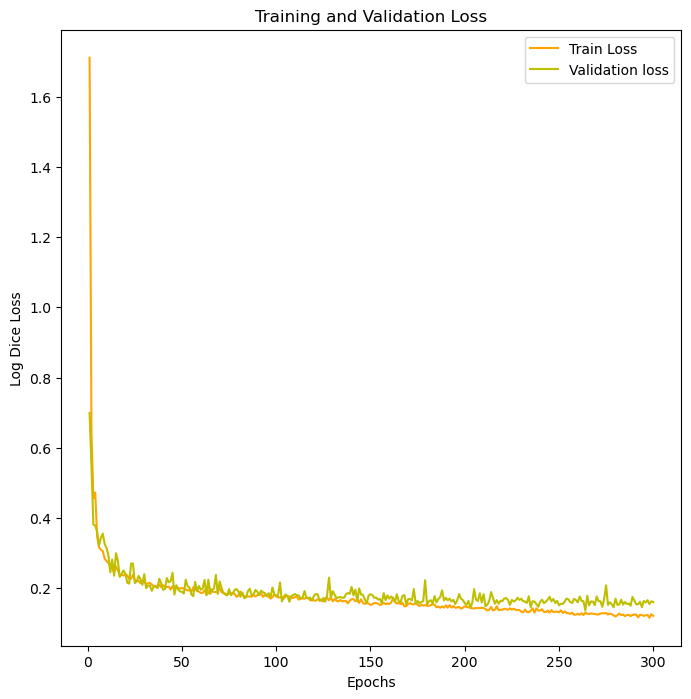

In [10]:
t_loss = history.history['loss']
val_loss = history.history['val_loss']
acc=history.history['dice_coef']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8, 8))
plt.plot(epochs, t_loss, 'orange', label='Train Loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Dice Loss')
# plt.grid()
plt.legend()

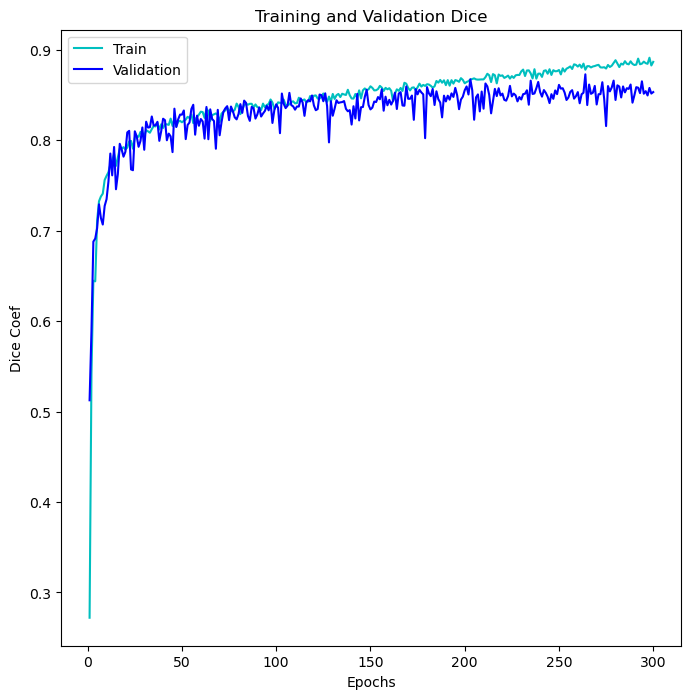

In [11]:
loss = history.history['loss']
acc=history.history['dice_coef']
val_acc=history.history['val_dice_coef']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8, 8))
plt.plot(epochs, acc, 'c', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Training and Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
# plt.grid()
plt.legend()

In [15]:
from skimage.morphology import dilation
from skimage.feature import canny
from skimage import color

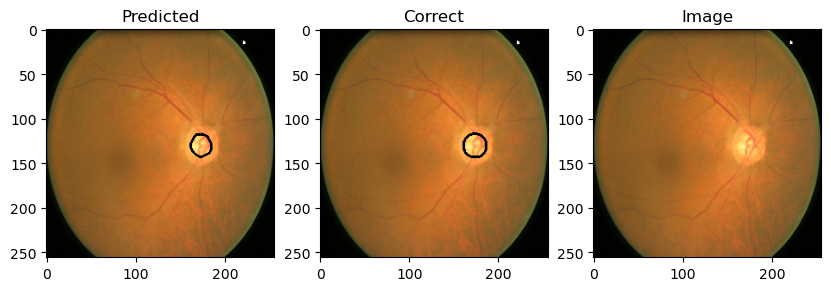

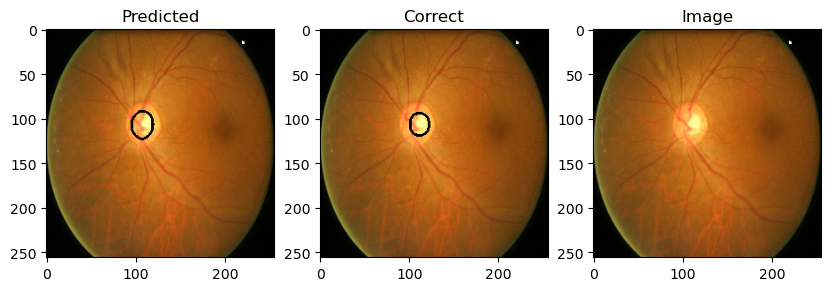

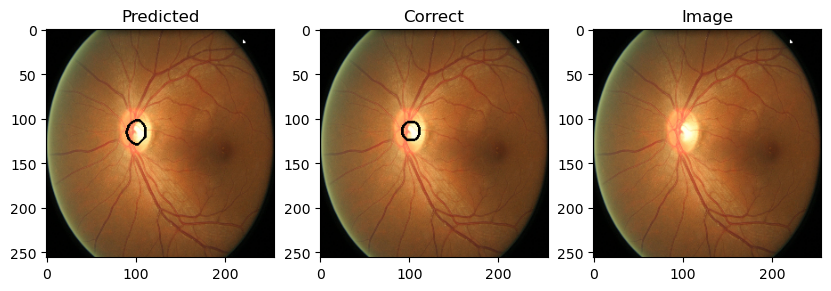

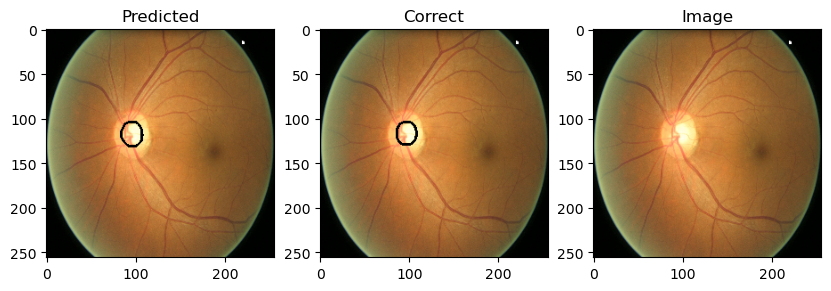

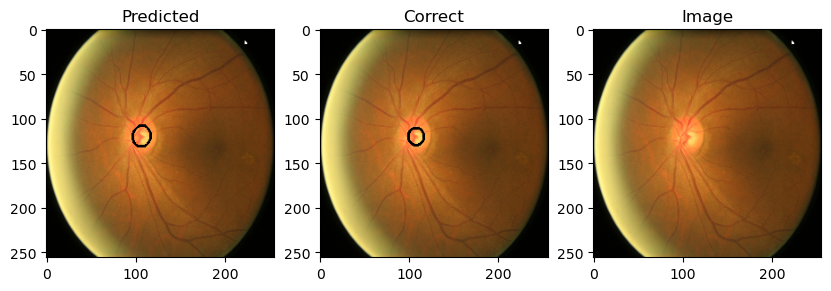

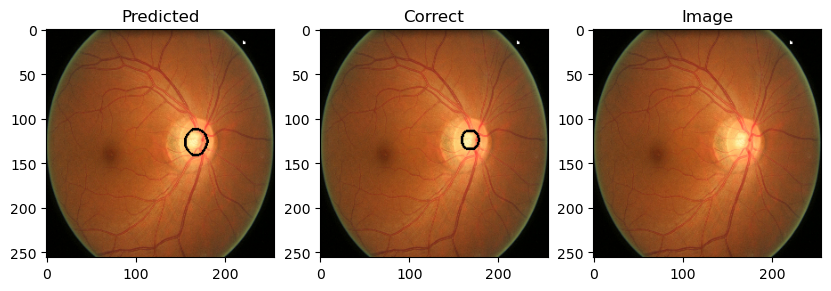

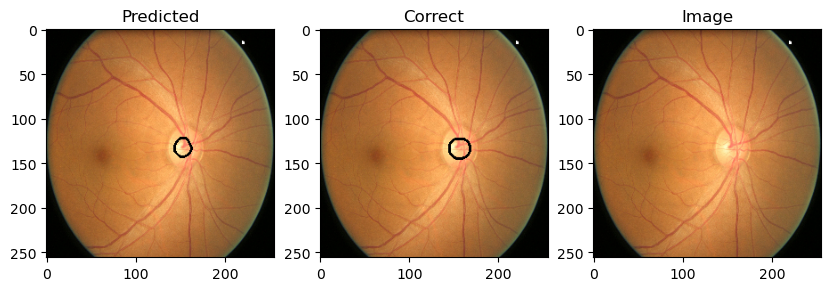

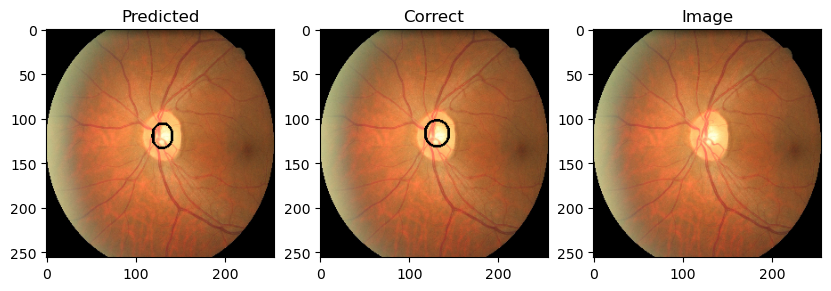

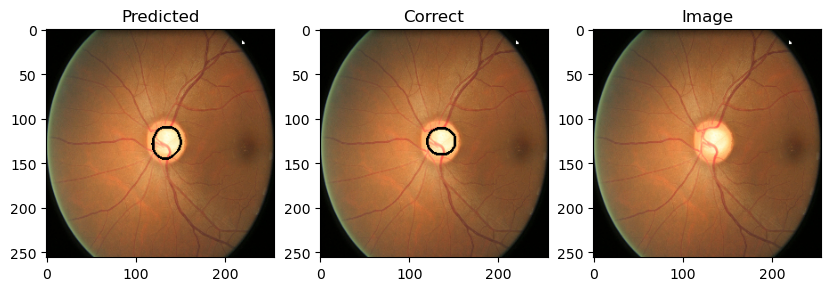

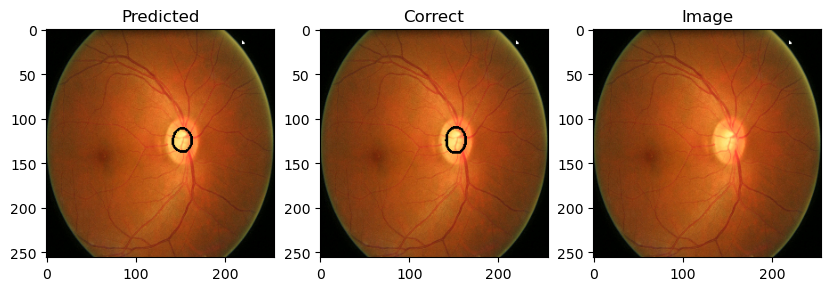

In [16]:
for image , mask, file_name in zip(X_test[: 10], Y_test[:10], name_test[:10]):

    x_test = image.copy()
    x_test = tf.image.resize(x_test, (128, 128))/122.5 - 1.0

    mask = (mask[:, :, 0] > 225.5) + 0.0
    

    pred = (model.predict(tf.expand_dims(x_test, axis=0), verbose=0)[0] > 0.5).astype(float)
    pred = cv2.resize(pred, (256, 256))

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Predicted')
    edgesp = canny(pred)
    edgesp = 1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow((image*edgesp).astype(int)[:, :, ::-1])


    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Correct')
    edgesc = canny(mask)
    edgesc = 1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow((image*edgesc).astype(int)[:, :, ::-1])

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Image')
    ax.imshow(image[:, :, ::-1])

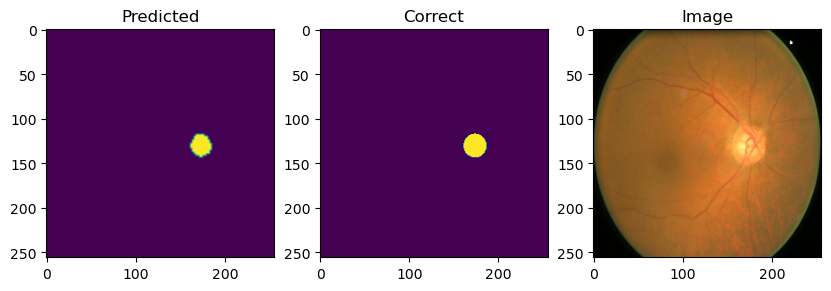

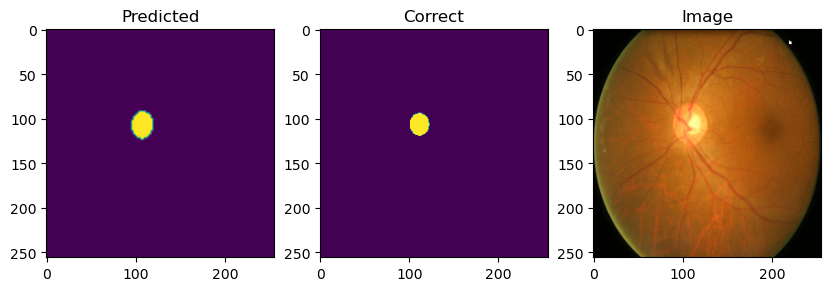

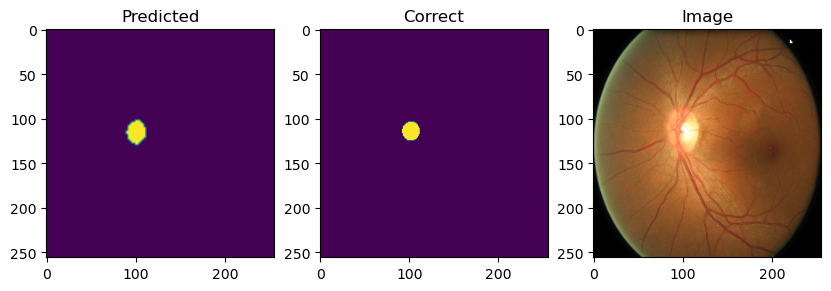

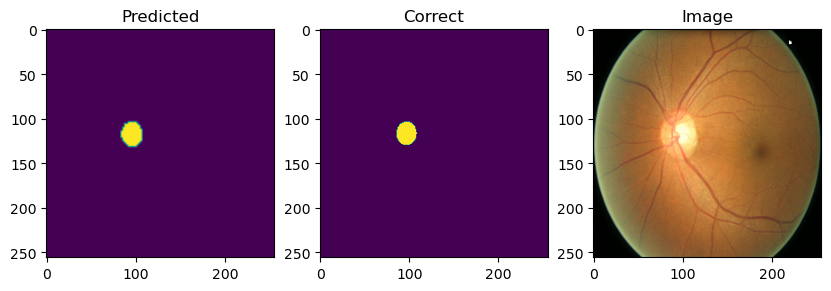

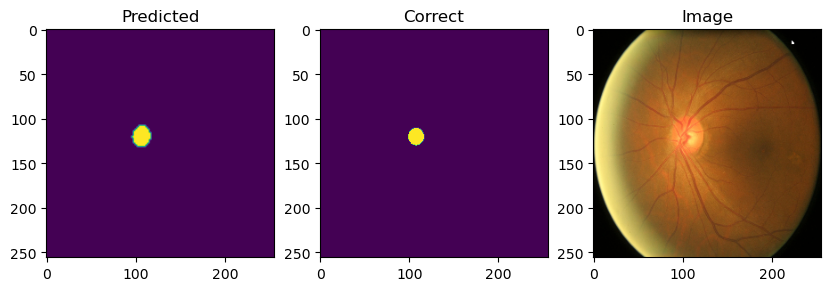

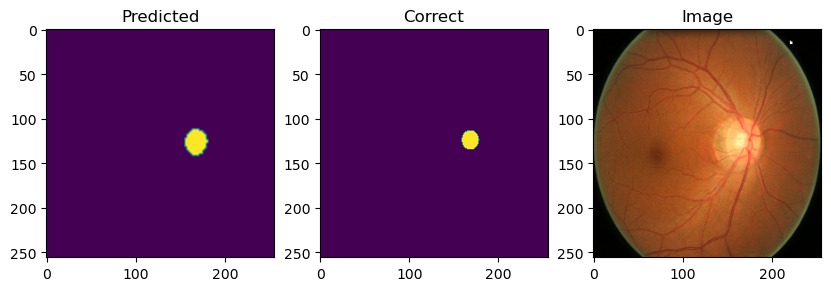

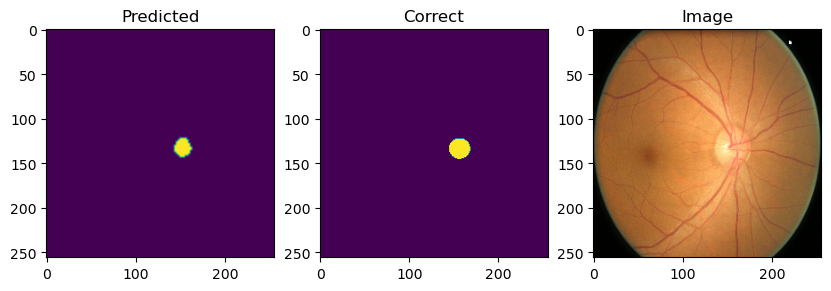

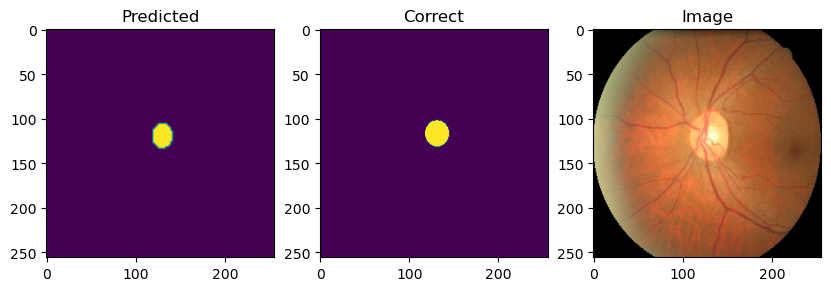

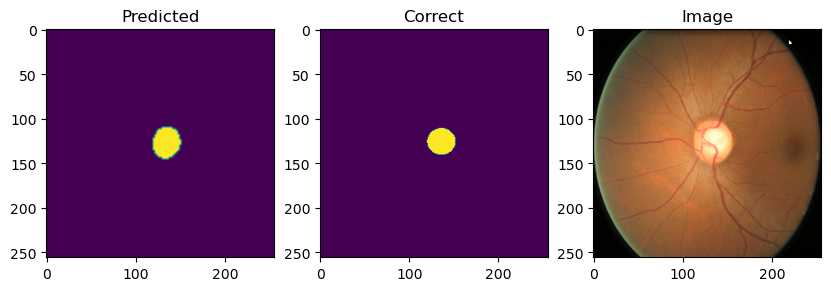

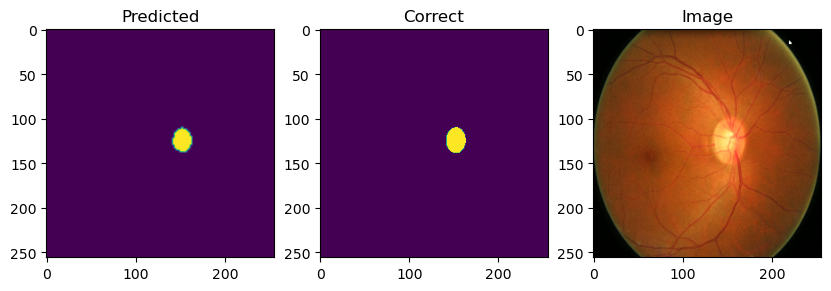

In [21]:
for image , mask, file_name in zip(X_test[: 10], Y_test[:10], name_test[:10]):

    x_test = image.copy()
    x_test = tf.image.resize(x_test, (128, 128))/122.5 - 1.0

    mask = (mask[:, :, 0] > 225.5) + 0.0
    

    pred = (model.predict(tf.expand_dims(x_test, axis=0), verbose=0)[0] > 0.5).astype(float)
    pred = cv2.resize(pred, (256, 256))

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Predicted')
#     edgesp = canny(pred)
#     edgesp = 1.0-dilation(edgesp)
#     edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(pred)


    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Correct')
#     edgesc = canny(mask)
#     edgesc = 1.0-dilation(edgesc)
#     edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(mask)

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Image')
    ax.imshow(image[:, :, ::-1])